In [1]:
from PIL import Image
import copy
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch
import numpy as np
import cv2

In [2]:
import os
os.chdir('./Transformer-Explainability')
from baselines.ViT.ViT_explanation_generator import LRP
from baselines.ViT.ViT_LRP import VisionTransformer

In [3]:
os.chdir('..')
from torchvision.transforms.functional import InterpolationMode
from conf_finetune import _C as cfg
from main_finetune import initialize_data_loader

transform = transforms.Compose([
    transforms.Resize((256, 128), interpolation=InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
def vit_base_patch16(cfg, num_classes):
    model = VisionTransformer(img_size=cfg.INPUT.IMAGE_SIZE, num_classes=num_classes,
        patch_size=16, embed_dim=768, depth=12, num_heads=12, mlp_ratio=4, qkv_bias=True)
    return model

model = vit_base_patch16(cfg, 1041).cuda()
model.eval()
attribution_generator = LRP(model)

In [5]:
# create heatmap from mask on image
def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return cam

def generate_visualization(original_image, class_index=None):
    transformer_attribution = attribution_generator.generate_LRP(original_image.unsqueeze(0).cuda(), method="transformer_attribution", index=class_index).detach()
    transformer_attribution = transformer_attribution.reshape(1, 1, 16, 8)
    transformer_attribution = torch.nn.functional.interpolate(transformer_attribution, scale_factor=16, mode='bilinear')
    transformer_attribution = transformer_attribution.reshape(256, 128).cuda().data.cpu().numpy()
    transformer_attribution = (transformer_attribution - transformer_attribution.min()) / (transformer_attribution.max() - transformer_attribution.min())
    image_transformer_attribution = original_image.permute(1, 2, 0).data.cpu().numpy()
    image_transformer_attribution = (image_transformer_attribution - image_transformer_attribution.min()) / (image_transformer_attribution.max() - image_transformer_attribution.min())
    vis = show_cam_on_image(image_transformer_attribution, transformer_attribution)
    vis =  np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    return vis

def print_top_classes(predictions, **kwargs):    
    # Print Top-5 predictions
    prob = torch.softmax(predictions, dim=1)
    class_indices = predictions.data.topk(5, dim=1)[1][0].tolist()
    max_str_len = 0
    class_names = []
    for cls_idx in class_indices:
        class_names.append(cls_idx)
        if len(str(cls_idx)) > max_str_len:
            max_str_len = len(str(cls_idx))
    
    print('Top 5 classes:')
    for cls_idx in class_indices:
        output_string = '\t{} : {}'.format(cls_idx, cls_idx)
        output_string += ' ' * (max_str_len - len(str(cls_idx))) + '\t\t'
        output_string += 'value = {:.3f}\t prob = {:.1f}%'.format(predictions[0, cls_idx], 100 * prob[0, cls_idx])
        print(output_string)

In [9]:
def load(f):
    snapshot = torch.load(f, map_location='cpu')
    state_dict = model.state_dict()
    for k in list(snapshot['model'].keys()):
        # atl model warps mae
        if k.startswith('mae'):
            snapshot['model'][k[4:]] = copy.deepcopy(snapshot['model'][k])
            del snapshot['model'][k]
            k = k[4:]
        if k not in state_dict or (snapshot['model'][k].shape != state_dict[k].shape and k != 'pos_embed'):
            del snapshot['model'][k]
    model.load_state_dict(snapshot['model'], strict=False)

/home/yanzuo/miniconda3/envs/smart/lib/python3.8/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


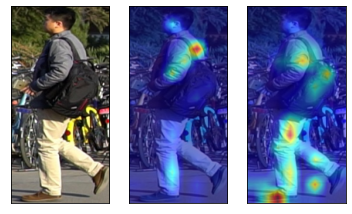

In [59]:
image = Image.open('/home/yanzuo/datasets/MSMT17_V2/mask_train_v2/0009/0009_016_07_0303morning_0112_0_ex.jpg')
image_trans = transform(image)

fig, axs = plt.subplots(1, 3)
axs[0].imshow(image.resize((128, 256)))
# axs[0].set_xlabel('(a)')
axs[0].set_xticks([])
axs[0].set_yticks([])

load('checkpoints/default.pth')
default = generate_visualization(image_trans)
load('checkpoints/with_cbm.pth')
with_cbm = generate_visualization(image_trans)

axs[1].imshow(default)
# axs[1].set_xlabel('(b)')
axs[1].set_xticks([])
axs[1].set_yticks([])

axs[2].imshow(with_cbm)
# axs[2].set_xlabel('(c)')
axs[2].set_xticks([])
axs[2].set_yticks([])

plt.savefig('vis1.eps', bbox_inches='tight', pad_inches = 0.1)

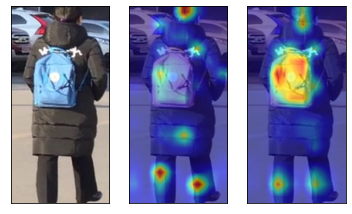

In [60]:
image = Image.open('/home/yanzuo/datasets/MSMT17_V2/mask_train_v2/0014/0014_017_05_0303morning_0202_0_ex.jpg')
image_trans = transform(image)

fig, axs = plt.subplots(1, 3)
axs[0].imshow(image.resize((128, 256)))
# axs[0].set_xlabel('(a)')
axs[0].set_xticks([])
axs[0].set_yticks([])

load('checkpoints/default.pth')
default = generate_visualization(image_trans)
load('checkpoints/with_cbm.pth')
with_cbm = generate_visualization(image_trans)

axs[1].imshow(default)
# axs[1].set_xlabel('(b)')
axs[1].set_xticks([])
axs[1].set_yticks([])

axs[2].imshow(with_cbm)
# axs[2].set_xlabel('(c)')
axs[2].set_xticks([])
axs[2].set_yticks([])

plt.savefig('vis2.eps', bbox_inches='tight', pad_inches = 0.1)

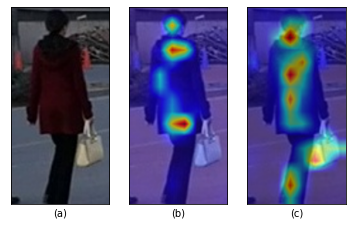

In [61]:
image = Image.open('/home/yanzuo/datasets/MSMT17_V2/mask_train_v2/0016/0016_011_15_0303morning_0426_0_ex.jpg')
image_trans = transform(image)

fig, axs = plt.subplots(1, 3)
axs[0].imshow(image.resize((128, 256)))
axs[0].set_xlabel('(a)')
axs[0].set_xticks([])
axs[0].set_yticks([])

load('checkpoints/default.pth')
default = generate_visualization(image_trans)
load('checkpoints/with_cbm.pth')
with_cbm = generate_visualization(image_trans)

axs[1].imshow(default)
axs[1].set_xlabel('(b)')
axs[1].set_xticks([])
axs[1].set_yticks([])

axs[2].imshow(with_cbm)
axs[2].set_xlabel('(c)')
axs[2].set_xticks([])
axs[2].set_yticks([])

plt.savefig('vis3.eps', bbox_inches='tight', pad_inches = 0.1)

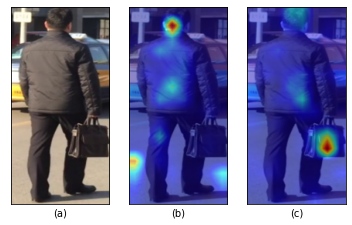

In [62]:
image = Image.open('/home/yanzuo/datasets/MSMT17_V2/mask_train_v2/0604/0604_016_05_0302morning_0632_0_ex.jpg')
image_trans = transform(image)

fig, axs = plt.subplots(1, 3)
axs[0].imshow(image.resize((128, 256)))
axs[0].set_xlabel('(a)')
axs[0].set_xticks([])
axs[0].set_yticks([])

load('checkpoints/default.pth')
default = generate_visualization(image_trans)
load('checkpoints/with_cbm.pth')
with_cbm = generate_visualization(image_trans)

axs[1].imshow(default)
axs[1].set_xlabel('(b)')
axs[1].set_xticks([])
axs[1].set_yticks([])

axs[2].imshow(with_cbm)
axs[2].set_xlabel('(c)')
axs[2].set_xticks([])
axs[2].set_yticks([])

plt.savefig('vis4.eps', bbox_inches='tight', pad_inches = 0.1)

In [36]:
from functools import partial

import torch
import torch.nn as nn
from timm.models.vision_transformer import Block, PatchEmbed

from utils.pos_embed import interpolate_pos_embed

In [26]:
class MaskedAutoencoderViT(nn.Module):
    """ Masked Autoencoder with VisionTransformer backbone
    """
    def __init__(self, img_size=224, patch_size=16, in_chans=3,
                 embed_dim=1024, depth=24, num_heads=16,
                 decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
                 mlp_ratio=4., norm_layer=nn.LayerNorm, norm_pix_loss=False):
        super().__init__()

        # --------------------------------------------------------------------------
        # MAE encoder specifics
        self.patch_embed = PatchEmbed(img_size, patch_size, in_chans, embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim), requires_grad=False)  # fixed sin-cos embedding

        self.blocks = nn.ModuleList([
            Block(embed_dim, num_heads, mlp_ratio, qkv_bias=True, norm_layer=norm_layer)
            for i in range(depth)])
        self.norm = norm_layer(embed_dim)
        # --------------------------------------------------------------------------

        # --------------------------------------------------------------------------
        # MAE decoder specifics
        self.decoder_embed = nn.Linear(embed_dim, decoder_embed_dim, bias=True)

        self.mask_token = nn.Parameter(torch.zeros(1, 1, decoder_embed_dim))

        self.decoder_pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, decoder_embed_dim), requires_grad=False)  # fixed sin-cos embedding

        self.decoder_blocks = nn.ModuleList([
            Block(decoder_embed_dim, decoder_num_heads, mlp_ratio, qkv_bias=True, norm_layer=norm_layer)
            for i in range(decoder_depth)])

        self.decoder_norm = norm_layer(decoder_embed_dim)
        self.decoder_pred = nn.Linear(decoder_embed_dim, patch_size**2 * in_chans, bias=True) # decoder to patch
        # --------------------------------------------------------------------------

        self.norm_pix_loss = norm_pix_loss

        self.initialize_weights()

    def initialize_weights(self):
        # initialization
        # initialize (and freeze) pos_embed by sin-cos embedding
        pos_embed = self.build_2d_sincos_position_embedding(self.pos_embed.shape[-1])
        self.pos_embed.data.copy_(pos_embed)

        decoder_pos_embed = self.build_2d_sincos_position_embedding(self.decoder_pos_embed.shape[-1])
        self.decoder_pos_embed.data.copy_(decoder_pos_embed)

        # initialize patch_embed like nn.Linear (instead of nn.Conv2d)
        w = self.patch_embed.proj.weight.data
        torch.nn.init.xavier_uniform_(w.view([w.shape[0], -1]))

        # timm's trunc_normal_(std=.02) is effectively normal_(std=0.02) as cutoff is too big (2.)
        torch.nn.init.normal_(self.cls_token, std=.02)
        torch.nn.init.normal_(self.mask_token, std=.02)

        # initialize nn.Linear and nn.LayerNorm
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            # we use xavier_uniform following official JAX ViT:
            torch.nn.init.xavier_uniform_(m.weight)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
    
    def build_2d_sincos_position_embedding(self, embed_dim, temperature=10000.):
        h, w = self.patch_embed.grid_size
        grid_w = torch.arange(w, dtype=torch.float32)
        grid_h = torch.arange(h, dtype=torch.float32)
        grid_w, grid_h = torch.meshgrid(grid_w, grid_h, indexing='xy')
        assert embed_dim % 4 == 0, 'Embed dimension must be divisible by 4 for 2D sin-cos position embedding'
        pos_dim = embed_dim // 4
        omega = torch.arange(pos_dim, dtype=torch.float32) / pos_dim
        omega = 1. / (temperature**omega)
        out_w = torch.einsum('m,d->md', [grid_w.flatten(), omega])
        out_h = torch.einsum('m,d->md', [grid_h.flatten(), omega])
        pos_emb = torch.cat([torch.sin(out_w), torch.cos(out_w), torch.sin(out_h), torch.cos(out_h)], dim=1)[None, :, :]

        pe_token = torch.zeros([1, 1, embed_dim], dtype=torch.float32)
        pos_embed = torch.cat([pe_token, pos_emb], dim=1)
        return pos_embed

    def patchify(self, imgs):
        """
        imgs: (N, 3, H, W)
        x: (N, L, patch_size**2 *3)
        """
        p = self.patch_embed.patch_size[0]
        assert imgs.shape[2] % p == 0, imgs.shape[3] % p == 0

        h, w = self.patch_embed.grid_size
        x = imgs.reshape(shape=(imgs.shape[0], 3, h, p, w, p))
        x = torch.einsum('nchpwq->nhwpqc', x)
        x = x.reshape(shape=(imgs.shape[0], h * w, p**2 * 3))
        return x

    def unpatchify(self, x):
        """
        x: (N, L, patch_size**2 *3)
        imgs: (N, 3, H, W)
        """
        p = self.patch_embed.patch_size[0]
        h, w = self.patch_embed.grid_size
        assert h * w == x.shape[1]
        
        x = x.reshape(shape=(x.shape[0], h, w, p, p, 3))
        x = torch.einsum('nhwpqc->nchpwq', x)
        imgs = x.reshape(shape=(x.shape[0], 3, h * p, w * p))
        return imgs

    def random_masking(self, x, mask_ratio):
        """
        Perform per-sample random masking by per-sample shuffling.
        Per-sample shuffling is done by argsort random noise.
        x: [N, L, D], sequence
        """
        N, L, D = x.shape  # batch, length, dim
        len_keep = int(L * (1 - mask_ratio))
        
        noise = torch.rand(N, L, device=x.device)  # noise in [0, 1]
        
        # sort noise for each sample
        ids_shuffle = torch.argsort(noise, dim=1)  # ascend: small is keep, large is remove
        ids_restore = torch.argsort(ids_shuffle, dim=1)

        # keep the first subset
        ids_keep = ids_shuffle[:, :len_keep]
        x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))

        # generate the binary mask: 0 is keep, 1 is remove
        mask = torch.ones([N, L], device=x.device)
        mask[:, :len_keep] = 0
        # unshuffle to get the binary mask
        mask = torch.gather(mask, dim=1, index=ids_restore)

        return x_masked, mask, ids_restore

    def forward_encoder(self, x, mask_ratio):
        # embed patches
        x = self.patch_embed(x)

        # add pos embed w/o cls token
        x = x + self.pos_embed[:, 1:, :]

        # masking: length -> length * mask_ratio
        x, mask, ids_restore = self.random_masking(x, mask_ratio)

        # append cls token
        cls_token = self.cls_token + self.pos_embed[:, :1, :]
        cls_tokens = cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        # apply Transformer blocks
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)

        return x, mask, ids_restore

    def forward_decoder(self, x, ids_restore):
        # embed tokens
        x = self.decoder_embed(x)

        # append mask tokens to sequence
        mask_tokens = self.mask_token.repeat(x.shape[0], ids_restore.shape[1] + 1 - x.shape[1], 1)
        x_ = torch.cat([x[:, 1:, :], mask_tokens], dim=1)  # no cls token
        x_ = torch.gather(x_, dim=1, index=ids_restore.unsqueeze(-1).repeat(1, 1, x.shape[2]))  # unshuffle
        x = torch.cat([x[:, :1, :], x_], dim=1)  # append cls token

        # add pos embed
        x = x + self.decoder_pos_embed

        # apply Transformer blocks
        for blk in self.decoder_blocks:
            x = blk(x)
        x = self.decoder_norm(x)

        # predictor projection
        x = self.decoder_pred(x)

        # remove cls token
        x = x[:, 1:, :]

        return x

    def forward_loss(self, imgs, pred, mask):
        """
        imgs: [N, 3, H, W]
        pred: [N, L, p*p*3]
        mask: [N, L], 0 is keep, 1 is remove, 
        """
        target = self.patchify(imgs)
        if self.norm_pix_loss:
            mean = target.mean(dim=-1, keepdim=True)
            var = target.var(dim=-1, keepdim=True)
            target = (target - mean) / (var + 1.e-6)**.5

        loss = (pred - target) ** 2
        loss = loss.mean(dim=-1)  # [N, L], mean loss per patch

        loss = (loss * mask).sum() / mask.sum()  # mean loss on removed patches
        return loss

    def forward(self, imgs, mask_ratio=0.75, return_latent=False):
        latent, mask, ids_restore = self.forward_encoder(imgs, mask_ratio)
        pred = self.forward_decoder(latent, ids_restore)  # [N, L, p*p*3]
        loss = self.forward_loss(imgs, pred, mask)
        if return_latent:
            return loss, [loss.item()], pred, mask, latent
        else:
            return loss, [loss.item()], pred, mask

In [27]:
def mae_vit_base_patch16_dec512d8b(cfg):
    model = MaskedAutoencoderViT(
        img_size=cfg.INPUT.IMAGE_SIZE, patch_size=16, embed_dim=768, depth=12, 
        num_heads=12, decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16, mlp_ratio=4, 
        norm_layer=partial(nn.LayerNorm, eps=1e-6), norm_pix_loss=cfg.MODEL.NORM_PIX_LOSS)
    return model


def mae_vit_large_patch16_dec512d8b(cfg):
    model = MaskedAutoencoderViT(
        img_size=cfg.INPUT.IMAGE_SIZE, patch_size=16, embed_dim=1024, depth=24, 
        num_heads=16, decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16, mlp_ratio=4, 
        norm_layer=partial(nn.LayerNorm, eps=1e-6), norm_pix_loss=cfg.MODEL.NORM_PIX_LOSS)
    return model


def mae_vit_huge_patch14_dec512d8b(cfg):
    model = MaskedAutoencoderViT(
        img_size=cfg.INPUT.IMAGE_SIZE, patch_size=14, embed_dim=1280, depth=32, 
        num_heads=16, decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16, mlp_ratio=4, 
        norm_layer=partial(nn.LayerNorm, eps=1e-6), norm_pix_loss=cfg.MODEL.NORM_PIX_LOSS)
    return model


# set recommended archs
mae_vit_base_patch16 = mae_vit_base_patch16_dec512d8b  # decoder: 512 dim, 8 blocks
mae_vit_large_patch16 = mae_vit_large_patch16_dec512d8b  # decoder: 512 dim, 8 blocks
mae_vit_huge_patch14 = mae_vit_huge_patch14_dec512d8b  # decoder: 512 dim, 8 blocks

In [48]:
def load(f, pos_embed_size=(16, 8)):
    snapshot = torch.load(f, map_location='cpu')
    state_dict = model.state_dict()
    for k in list(snapshot['model'].keys()):
        # atl model warps mae
        if k.startswith('mae'):
            snapshot['model'][k[4:]] = copy.deepcopy(snapshot['model'][k])
            del snapshot['model'][k]
            k = k[4:]
        if k not in state_dict or (snapshot['model'][k].shape != state_dict[k].shape and k != 'pos_embed' and k != 'decoder_pos_embed'):
            del snapshot['model'][k]
    interpolate_pos_embed(model, snapshot['model'], pos_embed_size, 'pos_embed')
    interpolate_pos_embed(model, snapshot['model'], pos_embed_size, 'decoder_pos_embed')
    return model.load_state_dict(snapshot['model'], strict=False)

In [49]:
import sys
import os
import requests

import torch
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

In [50]:
from conf_pretrain import _C as cfg
model = mae_vit_base_patch16(cfg)
# load('checkpoints/mae_inet_lup_vitb_ep800_ratio_optimized.pth')
load('checkpoints/mae_pretrain_vit_base_full.pth', pos_embed_size=(14, 14))

Position interpolate from 14x14 to 16x8
Position interpolate from 14x14 to 16x8


<All keys matched successfully>

In [51]:
# define the utils

imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

In [52]:
def run_one_image(img, model):
    x = torch.tensor(img)

    # make it a batch-like
    x = x.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x)

    # run MAE
    loss, _, y, mask = model(x.float(), mask_ratio=0.75)

    # target = model.patchify(torch.tensor(img).unsqueeze(dim=0))
    # mean = target.mean(dim=-1, keepdim=True)
    # var = target.var(dim=-1, keepdim=True)
    # y = y * (var + 1.e-6)**.5 + mean

    y = model.unpatchify(y)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()

    # visualize the mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
    
    x = torch.einsum('nchw->nhwc', x)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 4, 1)
    show_image(x[0], "original")

    plt.subplot(1, 4, 2)
    show_image(im_masked[0], "masked")

    plt.subplot(1, 4, 3)
    show_image(y[0], "reconstruction")

    plt.subplot(1, 4, 4)
    show_image(im_paste[0], "reconstruction + visible")

    plt.show()

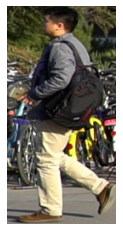

In [53]:
image = Image.open('/home/yanzuo/datasets/MSMT17_V2/mask_train_v2/0009/0009_016_07_0303morning_0112_0_ex.jpg')
image = image.resize((128, 256))
image = np.array(image) / 255.

image = image - imagenet_mean
image = image / imagenet_std

show_image(torch.tensor(image))

MAE with pixel reconstruction:


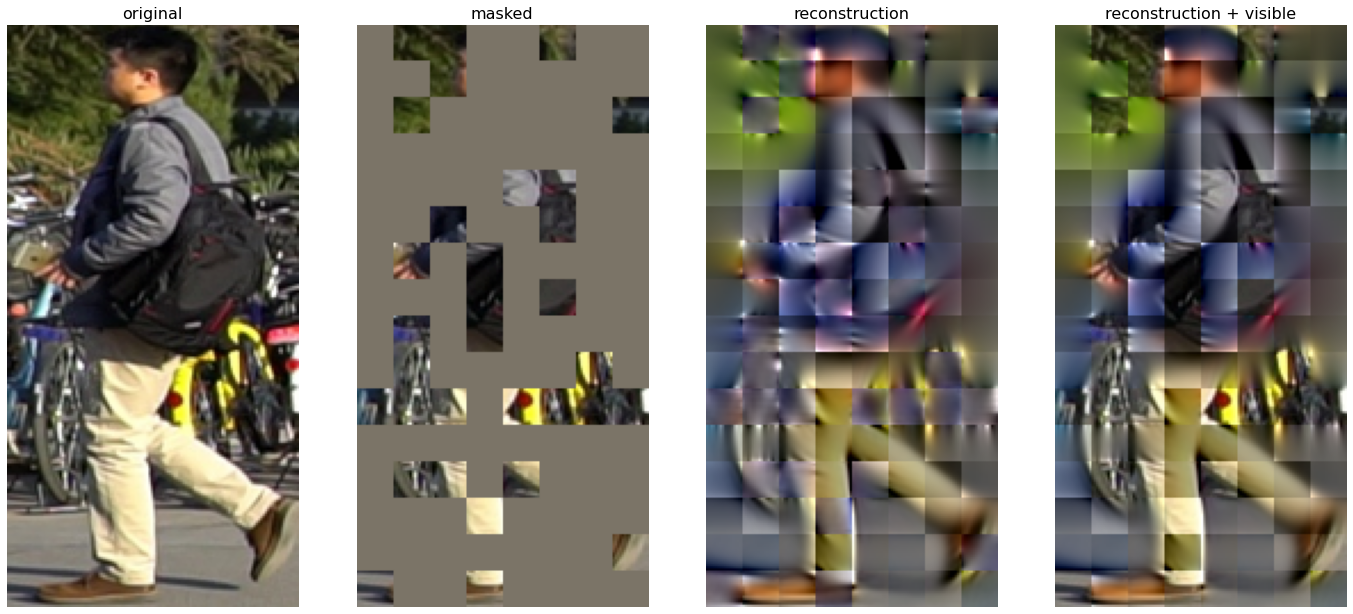

In [ ]:
torch.manual_seed(np.random.randint(2 ** 31))
print('MAE with pixel reconstruction:')
run_one_image(image, model)

MAE with pixel reconstruction:


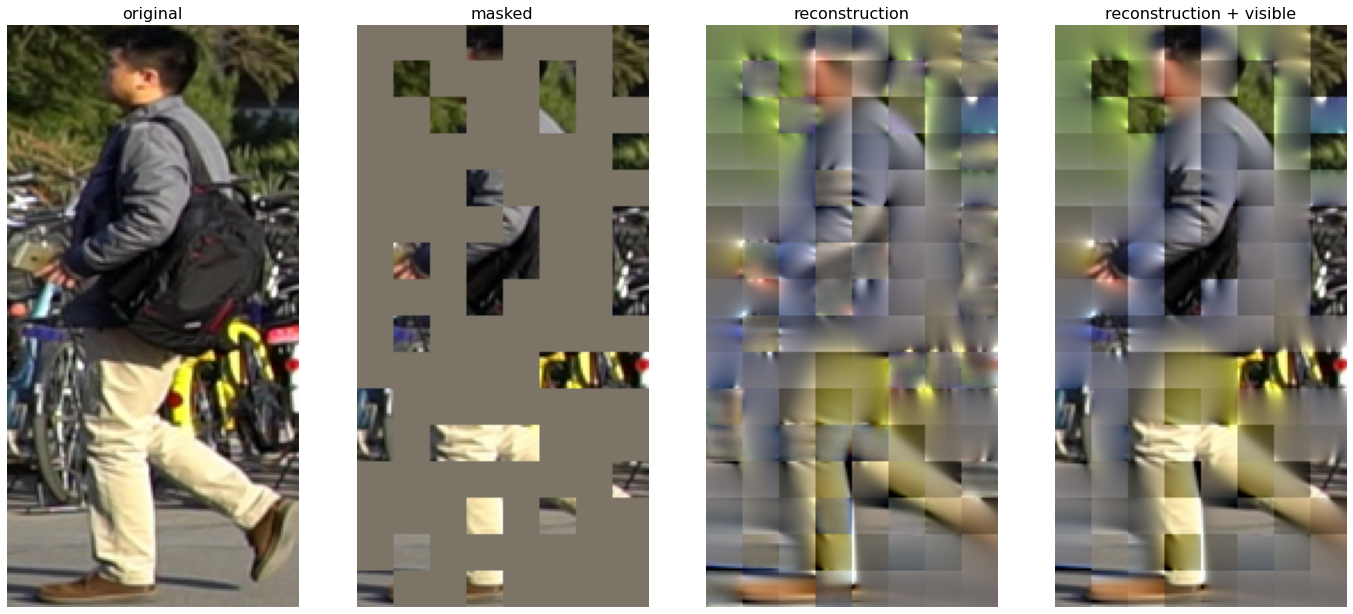

In [54]:
torch.manual_seed(np.random.randint(2 ** 31))
print('MAE with pixel reconstruction:')
run_one_image(image, model)